<a href="https://www.kaggle.com/code/inzeyun/notebookc2020bf0c0?scriptVersionId=165133879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## PHQ-9, ICD-10 Depression Scores
* Upon thinking, the explanation about this dataset is quite wrong
    * PHQ-9 scores are not longitudinal and only been used for initial diagnosis
    * [q for q in dataset.columns if q.startswith("q")] (ICD-10 Depression endpoints) is one of primary, longitudinal endpoints in the dataset
* Except of happiness.score, higher questionnarie results are worse

## Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from pathlib import Path
from matplotlib.font_manager import fontManager, FontProperties

fontPath="https://github.com/fonts-archive/Pretendard/raw/main/Pretendard-Regular.otf"
fontFile=Path("pretendard.otf")

res=requests.get(fontPath)
fontFile.write_bytes(res.content)

fontManager.addfont(fontFile)
fontProp=FontProperties(fname=fontFile)
sns.set(font=fontProp.get_name(),style="whitegrid",palette="muted")

In [2]:
datafile="/kaggle/input/phq-9-depression-assessment/Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv"
indices=["user_id","phq.day"]
gomi=["Unnamed: 0","id","start.time","time"]

In [3]:
data=pd.read_csv(datafile).drop(gomi,axis=1).dropna(subset=["phq1","phq9"])

In [4]:
data=data.sort_values(indices)
data.sample(3)

,user_id,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,...,q11,q12,q13,q14,q16,q46,q47,happiness.score,period.name,phq.day
15018,174,1.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,evening,-11.555428
12567,147,1.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2,evening,4.206377
210,2,2.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1,evening,-43.857847


## Take a Look

In [5]:
data.select_dtypes("number").agg([lambda q:q.isna().sum(),"mean","median","std","min","max"]).T.round(3)

,<lambda>,mean,median,std,min,max
user_id,0.0,96.957,101.000,54.196,1.000,185.000
phq1,0.0,1.784,2.000,0.971,0.000,3.000
phq2,0.0,2.068,2.000,1.030,0.000,3.000
phq3,0.0,2.077,2.000,0.992,0.000,3.000
phq4,0.0,2.396,3.000,0.837,0.000,3.000
phq5,0.0,1.585,2.000,1.153,0.000,3.000
phq6,0.0,1.848,2.000,1.203,0.000,3.000
phq7,0.0,1.778,2.000,1.066,0.000,3.000
phq8,0.0,1.044,1.000,1.011,0.000,3.000
phq9,0.0,1.262,1.000,1.129,0.000,3.000


<Axes: >

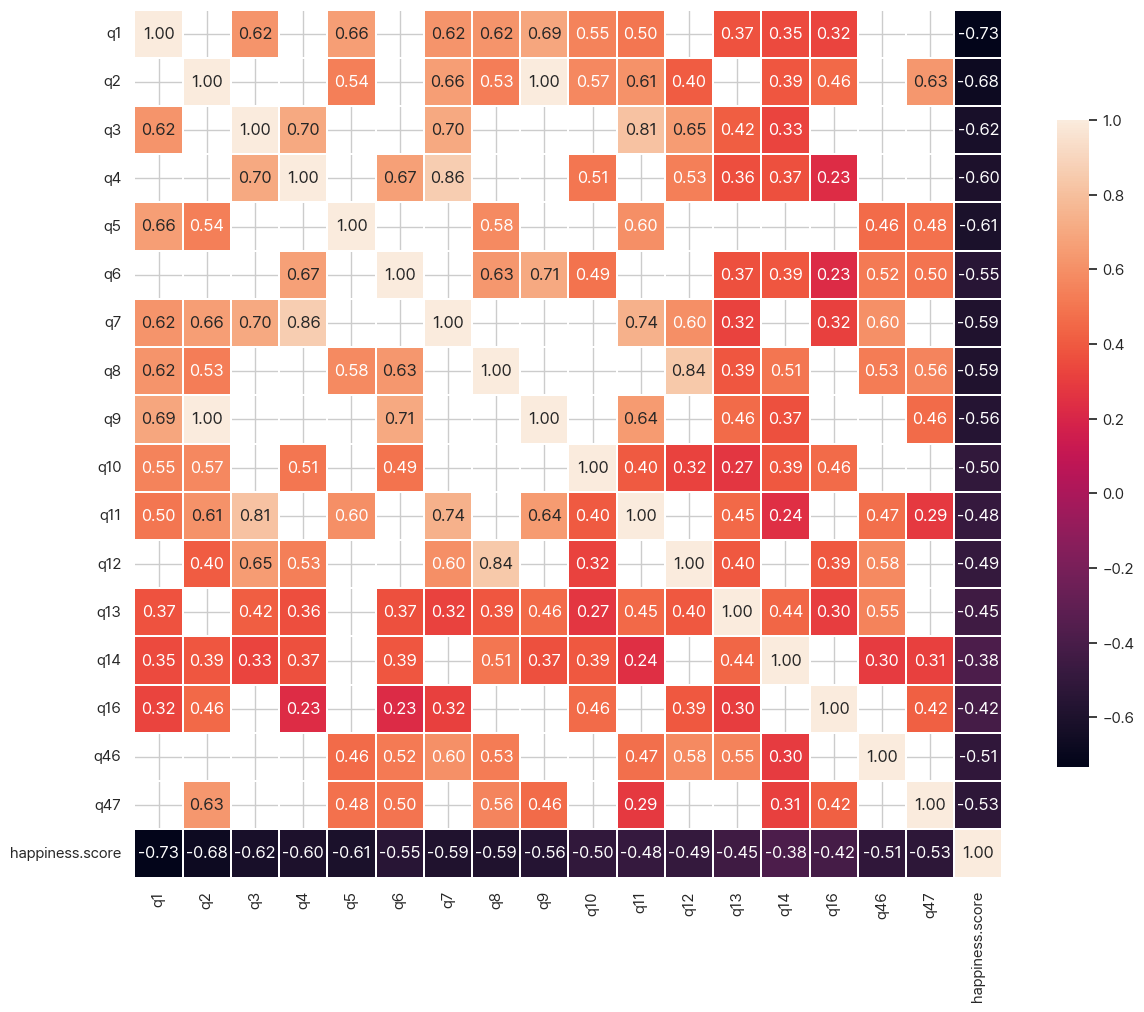

In [6]:
fg,ax=plt.subplots(figsize=(14,14))
sns.heatmap(
    data[[q for q in data.columns if q.startswith("q")]+["happiness.score"]].dropna(thresh=data.shape[0]*.1,axis=1).corr(),
    annot=True,fmt=".2f",linewidth=.25,square=True,cbar_kws={"shrink":.6},
    ax=ax)

## Make Spots
* Data is longitudinal and having 'phq.day' absolute time values
* I'm going to have more samples per spot, and spots would be an index for most values

In [7]:
mms=MinMaxScaler()
data["timedelta"]=data.groupby("user_id")["phq.day"].transform(
    lambda q:mms.fit_transform(q.to_numpy().reshape(-1,1)).reshape(-1)
)

In [8]:
longitudinalQs=[q for q in data.columns if q.startswith("q")]

data["spot"]=pd.qcut(data.timedelta,5,[q for q in range(1,6)])
perSpot=data.groupby("spot")[longitudinalQs].mean()

/tmp/ipykernel_18/1340815230.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  perSpot=data.groupby("spot")[longitudinalQs].mean()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


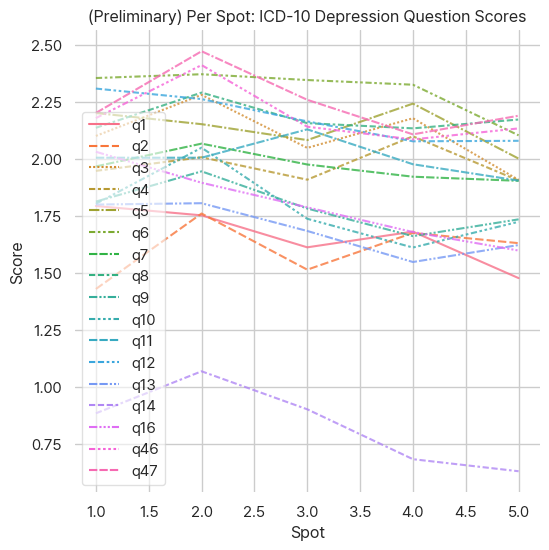

In [9]:
fig,ax=plt.subplots(figsize=(6,6))

sns.lineplot(perSpot,alpha=.8,ax=ax)

ax.set_title("(Preliminary) Per Spot: ICD-10 Depression Question Scores")
ax.set_xlabel("Spot")
ax.set_ylabel("Score")
sns.move_legend(
    obj=ax,
    loc="lower left",
    framealpha=.6
)
sns.despine(left=True,bottom=True)

## Get PHQ-9 Based Diagnosis

In [10]:
phqEssential=data.loc[:,["phq1","phq2"]].gt(1).all(axis=1)

phqZasal=data.loc[:,["phq9"]].gt(0).all(axis=1)

phqShaded=data.loc[phqEssential,[f"phq{q}" for q in range(1,9)]].gt(1).sum(axis=1)+phqZasal
phqShaded=phqShaded.fillna(0)
data["phqShaded"]=phqShaded

phq=data[[q for q in data.columns if q[-1].isdigit() and q[:3]=="phq"]].sum(axis=1)
data["phq"]=phq

In [11]:
idd=data[data.index.isin(data.groupby("user_id")["phq.day"].idxmin())].phqShaded.gt(3)
idd=data.user_id.isin(data[data.index.isin(idd.index)].user_id).rename("idd").apply(lambda q:"idd" if q else "")
idd.value_counts()

mdd=data.phqShaded.gt(4).rename("mdd").apply(lambda q:"mdd" if q else "")

odd=((1<data.phqShaded) * (data.phqShaded<5)).rename("odd").apply(lambda q:"odd" if q else "")

In [12]:
diag=(mdd+odd).rename("diag")
diag.loc[diag==""]="none"

data=pd.concat([ 
    data.drop("phq.day",axis=1),
    diag
],axis=1)

<Axes: xlabel='diag'>

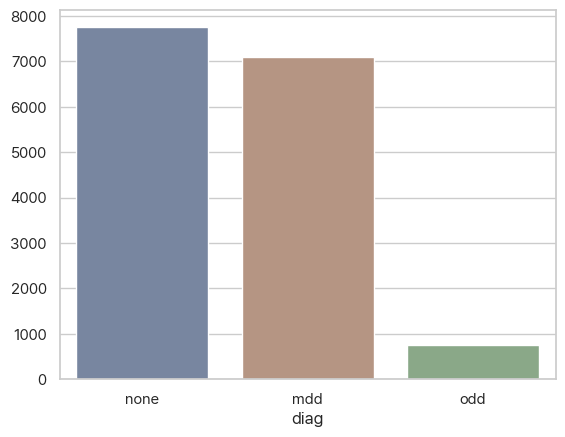

In [13]:
sns.barplot(data.diag.value_counts().to_frame().T,saturation=.3)

## Age Binning
* Going to have 5 bins for age

In [14]:
ageBin=pd.qcut(data.age,5)
data["age.bin"]=ageBin.cat.rename_categories(
    [f"{q.left:.1f}-{q.right:.1f}" for q in ageBin.cat.categories]
)

In [15]:
data_=data.melt(["user_id","spot","sex","age.bin","period.name","diag"],longitudinalQs)
data_.sample(5)

,user_id,spot,sex,age.bin,period.name,diag,variable,value
265361,184,5,male,33.0-39.0,evening,none,q47,NaN
237558,44,2,female,20.0-25.0,morning,mdd,q46,NaN
248292,170,4,female,NaN,evening,mdd,q46,3.0
59893,161,2,female,33.0-39.0,morning,mdd,q4,NaN
159705,47,3,female,12.0-20.0,midday,none,q11,NaN


<Axes: xlabel='age.bin'>

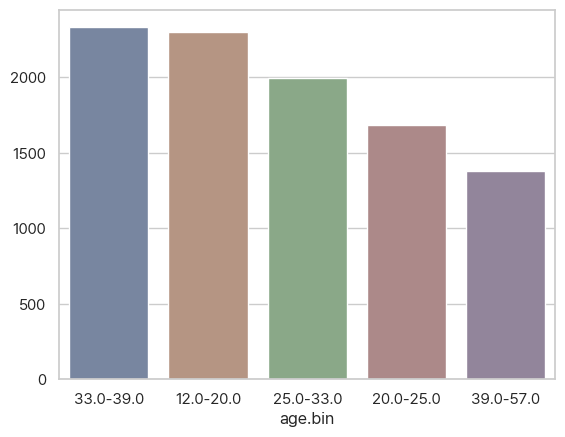

In [16]:
sns.barplot(data["age.bin"].value_counts().to_frame().T,saturation=.3)

## Per Category Plots
* Going to plot ICD-10 score means per categorical values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.02, 0.5, 'ICD-10 Mean Score')

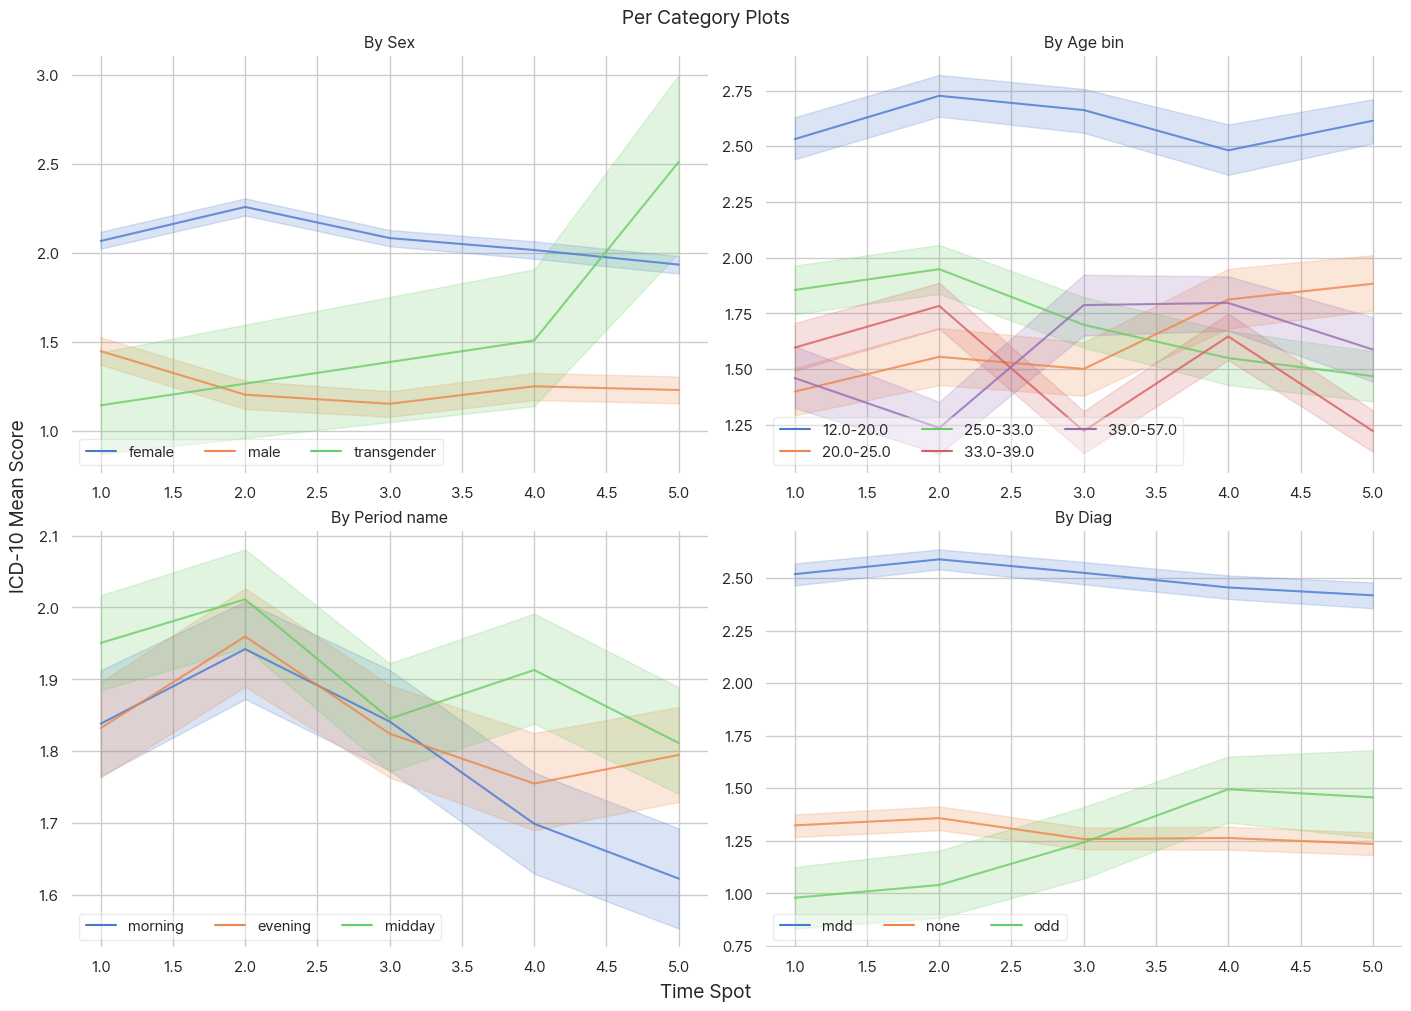

In [17]:
fg,ax=plt.subplots(2,2,figsize=(14,10),layout="constrained")

for q in list(zip(data_.columns[2:6],ax.ravel())):
    qLabel=q[0].replace("."," ").capitalize()

    sns.lineplot(
        data_,
        x="spot",
        y="value",
        hue=q[0],
        ax=q[1],
        alpha=.8,
    ).set(title=f"By {qLabel}",xlabel=None,ylabel=None)

    sns.move_legend(
        q[1],
        loc="lower left",
        title=None,
        ncols=3,
        framealpha=.4
    )

sns.despine(bottom=True,left=True)

fg.suptitle("Per Category Plots")
fg.supxlabel("Time Spot")
fg.supylabel("ICD-10 Mean Score")


* Per category plot by diagnosis
* MDD shows lower volatility than others and this may vary for extended time window
* High volatility of ODD diagnosed users indicates other possible illness

/tmp/ipykernel_18/1442578313.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z=data.groupby(["diag","spot"])[longitudinalQs].mean()


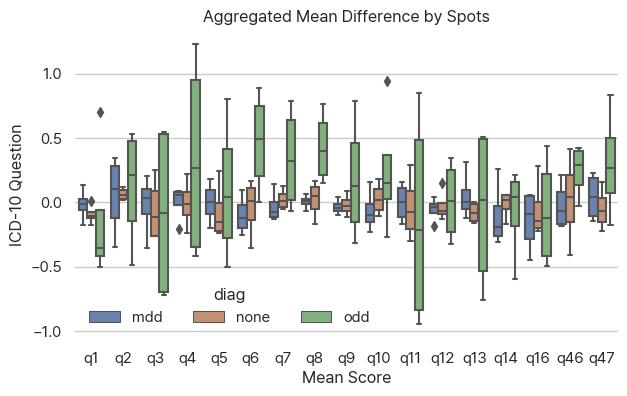

In [18]:
z=data.groupby(["diag","spot"])[longitudinalQs].mean()
fig,ax=plt.subplots(figsize=(7,4))
ax=sns.boxplot(
    z.groupby(["diag"]).diff().dropna(how="all").reset_index().melt(["spot","diag"]),
    x="variable",
    y="value",
    hue="diag",
    saturation=.5
)

ax.set_title("Aggregated Mean Difference by Spots")
ax.set_xlabel("Mean Score")
ax.set_ylabel("ICD-10 Question")

sns.move_legend(
    ax,
    "lower left",
    framealpha=.0,
    ncols=3
)
sns.despine(left=True,bottom=True)

## Categorical Score as Bin
* Like most self-report questionnaires, PHQ-9 scores can be used for categories
* I'm going to use the 6th (self-esteem) question with the highest std

In [19]:
byPhq=data.melt(["spot","phq6"],longitudinalQs)
byPhq.sample(3)

,spot,phq6,variable,value
171605,4,3.0,q11,NaN
101862,5,0.0,q7,NaN
8190,5,0.0,q1,NaN


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

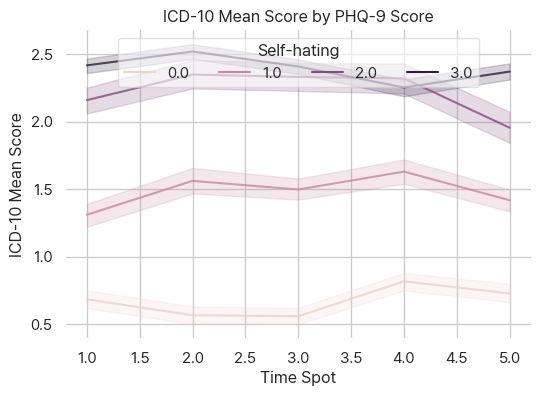

In [20]:
fg,ax=plt.subplots(figsize=(6,4))

sns.lineplot(
    byPhq,
    x="spot",
    y="value",
    hue="phq6",
    alpha=.8,
    ax=ax).set(title="ICD-10 Mean Score by PHQ-9 Score",
        xlabel="Time Spot",
        ylabel="ICD-10 Mean Score")

sns.move_legend(
    ax,
    loc="upper center",
    title="Self-hating",
    ncols=4,
    framealpha=.6
)

sns.despine(left=True,bottom=True)

## Happiness Score
* Happiness Score is just an aggregation of ICD-10 scores

In [21]:
areYouHappy=data.melt(["diag","sex","age.bin"],"happiness.score")

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


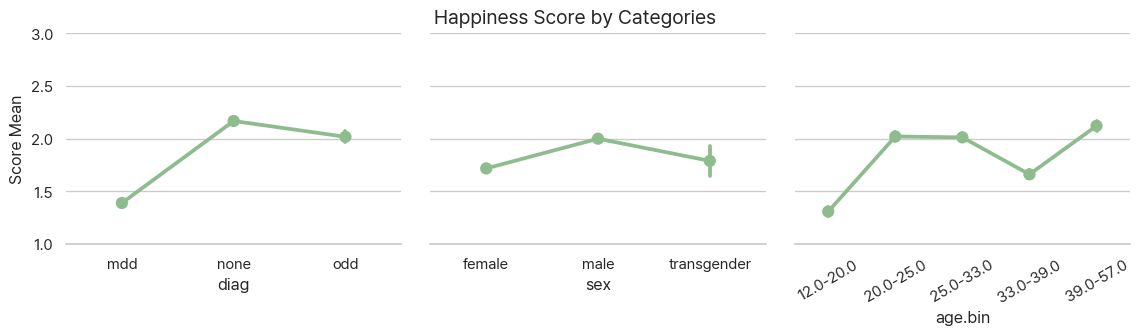

In [22]:
g=sns.PairGrid(
    areYouHappy,
    y_vars="value",x_vars=["diag","sex","age.bin"],
    height=3,aspect=1.3
)
g.tight_layout()
g.map(sns.pointplot,color="darkseagreen")
g.axes[0,2].tick_params(axis="x",rotation=30)
g.set(ylim=(1,3),ylabel="Score Mean")
g.figure.subplots_adjust(top=.9)
g.figure.suptitle("Happiness Score by Categories")
sns.despine(fig=g.fig,left=True)

## Clustering

In [23]:
from sklearn.cluster import AgglomerativeClustering

In [24]:
Ward=AgglomerativeClustering(n_clusters=3)

In [25]:
data.groupby(["spot"]).count()

/tmp/ipykernel_18/3073601013.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["spot"]).count()


,user_id,phq1,phq2,phq3,phq4,phq5,phq6,phq7,phq8,phq9,...,q16,q46,q47,happiness.score,period.name,timedelta,phqShaded,phq,diag,age.bin
spot,,,,,,,,,,,,,,,,,,,,,
1,3123,3123,3123,3123,3123,3123,3123,3123,3123,3123,...,303,249,369,3123,3123,3123,3123,3123,3123,1961
2,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,...,340,375,365,3122,3122,3122,3122,3122,3122,2021
3,3123,3123,3123,3123,3123,3123,3123,3123,3123,3123,...,375,385,410,3123,3123,3123,3123,3123,3123,1888
4,3122,3122,3122,3122,3122,3122,3122,3122,3122,3122,...,379,333,366,3122,3122,3122,3122,3122,3122,1912
5,3123,3123,3123,3123,3123,3123,3123,3123,3123,3123,...,462,406,429,3123,3123,3123,3123,3123,3123,1912
